In [1]:
import argparse
import os
import sys
import warnings
from fnmatch import fnmatch
import keras
import keras.preprocessing.image
import tensorflow as tf
ROOT_DIR = os.path.abspath("../")

# Allow relative imports when being executed as script.
sys.path.append(ROOT_DIR)

# Change these to absolute imports if you copy this script outside the keras_retinanet package.
import csv
from skimage.external.tifffile import TiffFile
from skimage.io import imread
import numpy
import skimage
from matplotlib import pyplot as plt
import random
import numpy as np
from scipy import ndimage
from scipy.ndimage.morphology import distance_transform_edt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
import tensorflow as tf
import os
import warnings
#import cv2
import numpy as np
from scipy import ndimage as ndi
from skimage.measure import label, regionprops
from skimage.filters import sobel_h, sobel_v
from skimage.measure import regionprops
from keras import backend as K
from keras.preprocessing.image import random_channel_shift,array_to_img, Iterator,ImageDataGenerator, NumpyArrayIterator
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import sys
import re


# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_maskrcnn import models
from keras_maskrcnn.utils.visualization import draw_mask
from keras_retinanet.utils.visualization import draw_box, draw_caption, draw_annotations
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


In [2]:
model_path = os.path.join('snapshots_mibi', '2resnet50_train_20.h5')
model = models.load_model(model_path, backbone_name='resnet50')
labels_to_names = {0: 'cell'}

/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:289: UserWarning: Output "filtered_detections" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "filtered_detections" during training.
  sample_weight_mode=sample_weight_mode)
/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [4]:
def deepcell_data_load():
    def list_file_deepcell(direc_name,training_direcs,raw_image_direc,channel_names):
        filelist=[]
        for b, direc in enumerate(training_direcs):
            imglist = os.listdir(os.path.join(direc_name, direc, raw_image_direc))
            #print(imglist)
            for c, channel in enumerate(channel_names):
                for img in imglist:
                    # if channel string is NOT in image file name, skip it.
                    if not fnmatch(img, '*{}*'.format(channel)):
                        continue
                    image_file = os.path.join(direc_name, direc, raw_image_direc, img)
                    filelist.append(image_file)
        return sorted(filelist)

    'Getting the data now'
    direc_name = "/data/data/tissues/mibi/samir"
    training_direcs = ['set1']
    raw_image_direc = 'raw'
    channel_names = ['dsDNA']
    train_imlist=list_file_deepcell(
        direc_name = direc_name,
        training_direcs = training_direcs,
        raw_image_direc = raw_image_direc,
        channel_names = channel_names)
    print(len(train_imlist))
    print("----------------")
    train_anotedlist=list_file_deepcell(
        direc_name = direc_name,
        training_direcs = training_direcs,
        raw_image_direc = 'annotated',
        channel_names = ['feature_1'])
    print(len(train_anotedlist))

    import random
    def randomcrops(dirpaths,maskpaths,sizeX,sizeY,iteration=1):
        img=cv2.imread(dirpaths[0],0)
        imgY=img.shape[0]
        imgX=img.shape[1]
        actX=imgX-sizeX
        actY=imgY-sizeY
        if actX<0 or actY<0:
            print("Image to crop is of a smaller size")
            return ([],[])
        outputi=[]
        outputm=[]
        while iteration>0:
            cropindex=[]
            for path in dirpaths:
                X=random.randint(0,actX)
                Y=random.randint(0,actY)
                cropindex.append((X,Y))
                image=cv2.imread(path,0)
                newimg=image[Y:Y+sizeY,X:X+sizeX]
                newimg=np.tile(np.expand_dims(newimg,axis=-1),(1,1,3))
                outputi.append(newimg)
            cnt=0
            for path in maskpaths:
                image=cv2.imread(path,0)
                X=cropindex[cnt][0]
                Y=cropindex[cnt][1]
                newimg=image[Y:Y+sizeY,X:X+sizeX]
                outputm.append(newimg)
                cnt=cnt+1
            iteration=iteration-1
        return (outputi,outputm)

    store=randomcrops(train_imlist,train_anotedlist,200,200,iteration=1)
    return store

In [5]:
store = deepcell_data_load()

1
----------------
1


In [7]:
print(store[0][0].shape)
print(store[1][0].shape)

(200, 200, 3)
(200, 200)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


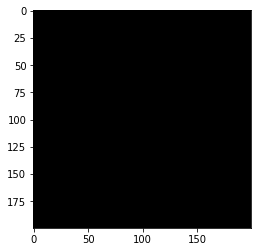

In [10]:
add = np.ones(store[0][0].shape)*100
img = (store[0][0]+add)/110
img3 = store[0][0]/np.max(store[0][0])
res = np.where(img>np.min(img),img3,0)
plt.imshow(img3)
plt.imsave("just_see.png",img)

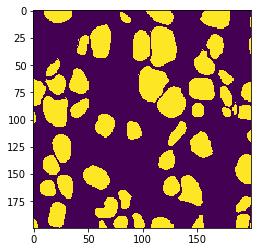

In [11]:
plt.imshow(store[1][0])

processing time:  0.5239391326904297


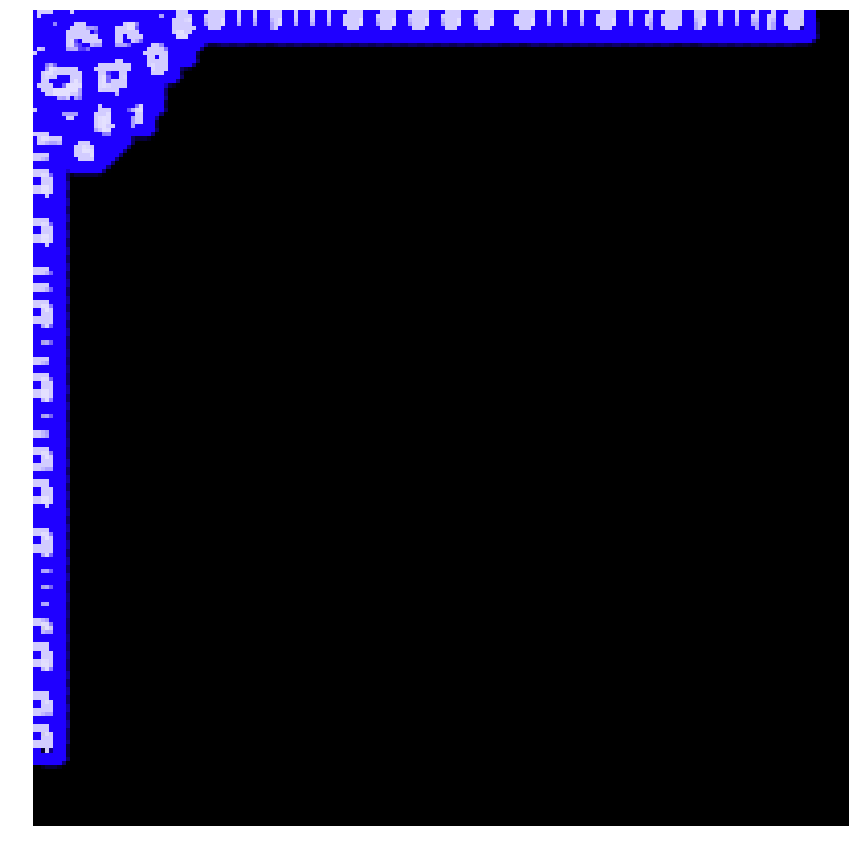

In [15]:
# load image
image = store[0][0]

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
outputs = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

boxes  = outputs[-4][0]
scores = outputs[-3][0]
labels = outputs[-2][0]
masks  = outputs[-1][0]

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label, mask in zip(boxes, scores, labels, masks):
    if score < 0.1:
        break

    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    mask = mask[:, :, label]
    draw_mask(draw, b, mask, color=label_color(label))
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    #draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()